<a href="https://colab.research.google.com/github/pd8459/PINN/blob/main/PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/PINN_ex1.xlsx')

In [ ]:
train_time = 40
x_train = torch.Tensor(data.loc[:train_time,'time'].values).reshape(-1,1).to(device)
y_train = torch.Tensor(data.loc[:train_time,'Height(m)'].values).reshape(-1,1).to(device)

x_test = torch.Tensor(data.loc[train_time+1:,'time'].values).reshape(-1,1).to(device)
y_test = torch.Tensor(data.loc[train_time+1:,'Height(m)'].values).reshape(-1,1).to(device)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.l1 = nn.Linear(1, 50)
        self.l2 = nn.Linear(50, 50)
        self.l3 = nn.Linear(50, 50)
        self.l4 = nn.Linear(50,1)
        self .relu = nn.ReLU()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        return x


In [ ]:
torch.cuda.manual_seed(123)
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
loss_train_record = []
loss_test_record = []
for epoch in range(10000):
  optimizer.zero_grad()

  preds_train = model(x_train)
  preds_test = model(x_test)

  loss_train = nn.MSELoss()(preds_train,y_train)
  loss_test = nn.MSELoss()(preds_test,y_test)

  loss_train.backward()
  optimizer.step()

  loss_train_record.append(loss_train.item())
  loss_test_record.append(loss_test.item())
  if epoch % 1000 == 0:
    print(f'epoch:{epoch} loss:{loss_train.item()}, loss_valid:{loss_test.item()}')

epoch:0 loss:808866.1875, loss_valid:181397.140625
epoch:1000 loss:379.4808654785156, loss_valid:366865.4375
epoch:2000 loss:181.9732208251953, loss_valid:337367.46875
epoch:3000 loss:50.02219009399414, loss_valid:278154.1875
epoch:4000 loss:14.873496055603027, loss_valid:243770.203125
epoch:5000 loss:5.755492210388184, loss_valid:216927.515625
epoch:6000 loss:1.637254238128662, loss_valid:194277.78125
epoch:7000 loss:1.1663835048675537, loss_valid:189656.046875
epoch:8000 loss:1.0649218559265137, loss_valid:189750.40625
epoch:9000 loss:0.9392520189285278, loss_valid:189693.203125


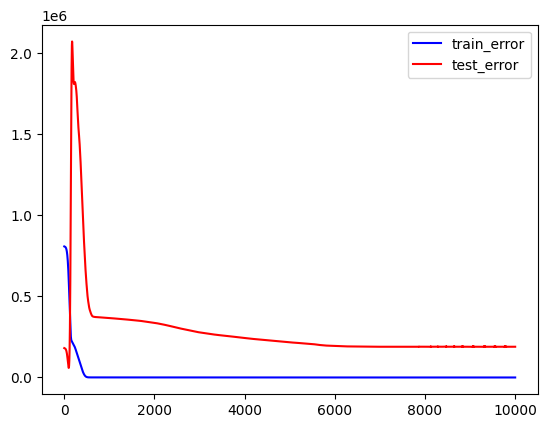

In [ ]:
plt.plot(loss_train_record,'b',label='train_error')
plt.plot(loss_test_record,'r',label='test_error')
plt.legend()
plt.show()

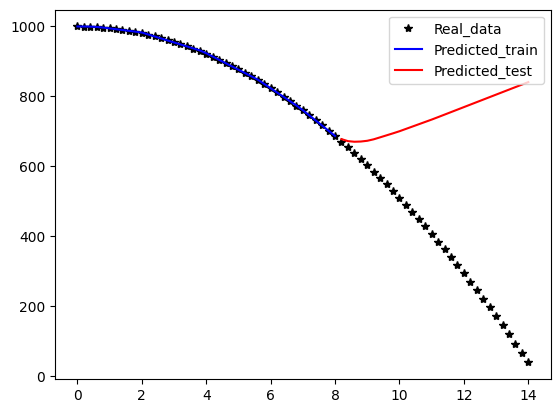

In [ ]:
with torch.no_grad():
  plt.plot(data['time'],data['Height(m)'],'*',color='black',label='Real_data')
  plt.plot(x_train.cpu(),preds_train.cpu(),color='blue',label='Predicted_train')
  plt.plot(x_test.cpu(),preds_test.cpu(),color='red',label='Predicted_test')
  plt.legend(loc = 'upper right')


In [ ]:
def ODE(t):
  return -9.8*t

In [ ]:
x_H0=torch.Tensor([0])
y_H0=torch.Tensor([1000])

In [ ]:
time_start = data.loc[0,'time']
time_end = data.loc[len(data)-1,'time']

N_colloc = 1000

X_colloc = torch.rand(N_colloc,1)*(time_end-time_start)+time_start

In [ ]:
X_colloc=X_colloc.to(device)
x_H0=x_H0.to(device)
y_H0=y_H0.to(device)

In [ ]:
class PINN_test(nn.Module):
    def __init__(self):
        super().__init__()
        self.tanh = nn.Tanh()
        self.l1 = nn.Linear(1,50)
        self.l2 = nn.Linear(50, 50)
        self.l3 = nn.Linear(50, 50)
        self.l4 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.l1(x)
        x = self.tanh(x)
        x = self.l2(x)
        x = self.tanh(x)
        x = self.l3(x)
        x = self.tanh(x)
        x = self.l4(x)
        return x

In [ ]:
torch.cuda.manual_seed(123)
model_P = PINN_test().to(device)
optimizer_P = torch.optim.Adam(model_P.parameters(), lr = 0.005)

In [ ]:
loss_train_P=[]
loss_test_P=[]
for epoch in range(30000):
    loss_BC=nn.MSELoss()(model_P.forward(x_H0),y_H0)
    X_colloc.requires_grad=True
    f=model_P.forward(X_colloc)
    f_x=torch.autograd.grad(f,X_colloc,torch.ones([X_colloc.shape[0],1]).to(device),
                      retain_graph=True, create_graph=True)[0]
    loss_ODE=nn.MSELoss()(f_x,ODE(X_colloc))
    loss_Data=nn.MSELoss()(model_P.forward(x_train),y_train)

loss = loss_BC + loss_ODE + loss_Data
loss_test = nn.MSELoss()(model_P.forward(x_test),y_test)
optimizer_P.zero_grad()
loss.backward()
optimizer_P.step()

loss_train_P.append(loss.item())
loss_test_P.append(loss_test.item())
if epoch % 1000 == 0:
  print(f'epoch:{epoch} loss:{loss.item()}, loss_valid:{loss_test.item()}')

